### Import data and define useful staff

In [32]:
from io import StringIO
import pandas as pd
import os

diagonal_sg_mpi_pd = pd.read_csv("../test_mpi/wavefront_diagonal_sg_mpi/20241022_144027/wavefront_runtimes.csv")

diagonal_allg_mpi_pd = pd.read_csv("../test_mpi/wavefront_diagonal_allg_mpi/20241021_000232/wavefront_runtimes.csv")
triangles_allg_mpi_pd = pd.read_csv("../test_mpi/wavefront_triangles_allg_mpi/20241021_021044/wavefront_runtimes.csv")

diagonal_ff_pd = pd.read_csv("../test_fastflow/wavefront_diagonal_ff/20241019_214949/wavefront_runtimes.csv")
triangles_ff_pd = pd.read_csv("../test_fastflow/wavefront_triangles_ff/20241019_215007/wavefront_runtimes.csv")

diagonal_pd = pd.read_csv("../test_sequential/wavefront_diagonal/20241020_164223/wavefront_runtimes.csv")
triangles_pd = pd.read_csv("../test_sequential/wavefront_triangles/20241020_164245/wavefront_runtimes.csv")

diagonal_sg_mpi = diagonal_sg_mpi_pd.to_dict(orient='records')

diagonal_allg_mpi = diagonal_allg_mpi_pd.to_dict(orient='records')
triangles_allg_mpi = triangles_allg_mpi_pd.to_dict(orient='records')

diagonal_ff = diagonal_ff_pd.to_dict(orient='records')
triangles_ff = triangles_ff_pd.to_dict(orient='records')

diagonal_seq = diagonal_pd.to_dict(orient='records')
triangles_seq = triangles_pd.to_dict(orient='records')

print(diagonal_seq)

[{'Name': 'wavefront_diagonal', 'Matrix size': 2048, 'Time': 1405, 'Value': 680.244}, {'Name': 'wavefront_diagonal', 'Matrix size': 2896, 'Time': 4725, 'Value': 962.795}, {'Name': 'wavefront_diagonal', 'Matrix size': 4096, 'Time': 13840, 'Value': 1362.68}, {'Name': 'wavefront_diagonal', 'Matrix size': 5793, 'Time': 39287, 'Value': 1928.23}, {'Name': 'wavefront_diagonal', 'Matrix size': 8192, 'Time': 108162, 'Value': 2727.78}]


In [33]:
size = [2048, 2896, 4096, 5793, 8192]
processes = [1, 2, 4, 8, 16, 32]

class CSVKeys:
     name = 'Version'
     size = 'Matrix size'
     workers = 'Workers number'
     triangles = 'Triangles number'
     runtime = 'Time'
     value ='Value'

class DATAKeys:
        processors = 'processors'
        runtime_diagonal ='runtime_diagonal_par'
        runtime_triangle ='runtime_triangle_par'
        T_seq = 'T_seq'
        path = 'path'
        size = 'size'

class Version:
     seq = 'sequential'
     mpi = 'mpi'
     ff = 'fastflow'

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_analysis(
    processors,
    runtime,
    cost,
    speedup,
    efficiency,
    title,
    runtime2,
    cost2,
    speedup2,
    efficiency2,
    title2,
    filename
):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    def add_table(ax, values1, values2, label1, label2):
        cell_text = [values1, values2]
        row_labels = [label1, label2]
        table = ax.table(cellText=cell_text,
                        rowLabels=row_labels,
                        cellLoc='center',
                        rowLoc='center',
                        loc='bottom',
                        bbox=[0, -0.4, 1, 0.2])
        table.scale(1, 1.2)

    axs[0, 0].plot(processors, runtime, color='orange', label=f'Runtime {title}')
    axs[0, 0].plot(processors, runtime2, color='blue', label=f'Runtime {title2}', linestyle='--')
    axs[0, 0].set_title(f'Runtime (ms)')
    axs[0, 0].set_xlabel('Processors (p)')
    axs[0, 0].set_ylabel('Runtime (ms)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    add_table(axs[0, 0], runtime, runtime2, f'Runtime {title} (ms)', f'Runtime {title2} (ms)')

    axs[0, 1].plot(processors, cost, color='orange', label=f'Cost {title}')
    axs[0, 1].plot(processors, cost2, color='blue', label=f'Cost {title2}', linestyle='--')
    axs[0, 1].set_title(f'Cost')
    axs[0, 1].set_xlabel('Processors (p)')
    axs[0, 1].set_ylabel('Cost')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    add_table(axs[0, 1], cost, cost2, f'Cost {title}', f'Cost {title2}')

    axs[1, 0].plot(processors, speedup, color='orange', label=f'Speedup {title}')
    axs[1, 0].plot(processors, speedup2, color='blue', label=f'Speedup {title2}', linestyle='--')
    axs[1, 0].set_title(f'Speedup')
    axs[1, 0].set_xlabel('Processors (p)')
    axs[1, 0].set_ylabel('Speedup')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    add_table(axs[1, 0], speedup, speedup2, f'Speedup {title}', f'Speedup {title2}')

    axs[1, 1].bar(processors, efficiency, color='orange', label=f'Efficiency {title}', width=0.4, align='center')
    axs[1, 1].bar(np.array(processors) + 0.4, efficiency2, color='blue', label=f'Efficiency {title2}', width=0.4, align='center')
    axs[1, 1].set_title('Efficiency (in %)')
    axs[1, 1].set_xlabel('Processors (p)')
    axs[1, 1].set_ylabel('Efficiency (%)')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    add_table(axs[1, 1], efficiency, efficiency2, f'Efficiency {title}', f'Efficiency {title2}')

    plt.tight_layout()

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_single_analysis(
    processors,
    runtime,
    cost,
    speedup,
    efficiency,
    title,
    filename
):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    def add_table(ax, values1, label1):
        cell_text = [values1]
        row_labels = [label1]
        table = ax.table(cellText=cell_text,
                        rowLabels=row_labels,
                        cellLoc='center',
                        rowLoc='center',
                        loc='bottom',
                        bbox=[0, -0.4, 1, 0.2])
        table.scale(1, 1.2)

    axs[0, 0].plot(processors, runtime, color='orange', label=f'Runtime {title}')
    axs[0, 0].set_title(f'Runtime (ms)')
    axs[0, 0].set_xlabel('Processors (p)')
    axs[0, 0].set_ylabel('Runtime (ms)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    add_table(axs[0, 0], runtime, f'Runtime {title} (ms)')

    axs[0, 1].plot(processors, cost, color='orange', label=f'Cost {title}')
    axs[0, 1].set_title(f'Cost')
    axs[0, 1].set_xlabel('Processors (p)')
    axs[0, 1].set_ylabel('Cost')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    add_table(axs[0, 1], cost, f'Cost {title}')

    axs[1, 0].plot(processors, speedup, color='orange', label=f'Speedup {title}')
    axs[1, 0].set_title(f'Speedup')
    axs[1, 0].set_xlabel('Processors (p)')
    axs[1, 0].set_ylabel('Speedup')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    add_table(axs[1, 0], speedup, f'Speedup {title}')

    axs[1, 1].bar(processors, efficiency, color='orange', label=f'Efficiency {title}', width=0.4, align='center')
    axs[1, 1].set_title('Efficiency (in %)')
    axs[1, 1].set_xlabel('Processors (p)')
    axs[1, 1].set_ylabel('Efficiency (%)')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    add_table(axs[1, 1], efficiency, f'Efficiency {title}')

    plt.tight_layout()

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()


In [35]:
def computeMetrics(strong_scalability_item):
    processors = strong_scalability_item[DATAKeys.processors]
    runtime_diag_par = strong_scalability_item[DATAKeys.runtime_diagonal]
    runtime_tria_par = strong_scalability_item[DATAKeys.runtime_triangle]
    T_seq = strong_scalability_item[DATAKeys.T_seq]

    speedup_diag = []
    speedup_tria = []
    if isinstance(T_seq, list):
        speedup_diag = [round(t / r, 2) for t, r in zip(T_seq, runtime_diag_par)]
        speedup_tria = [round(t / r, 2) for t, r in zip(T_seq, runtime_tria_par)]
    else:
        speedup_diag = [round(T_seq / r, 2) for r in runtime_diag_par]
        speedup_tria = [round(T_seq / r, 2) for r in runtime_tria_par]


    cost_diag = [r * p for r, p in zip(runtime_diag_par, processors)]
    cost_tria = [r * p for r, p in zip(runtime_tria_par, processors)]


    efficiency_diag = [round(100 * s / p, 2) for s, p in zip(speedup_diag, processors)]
    efficiency_tria = [round(100 * s / p, 2) for s, p in zip(speedup_tria, processors)]

    return (
        runtime_diag_par,
        speedup_diag,
        cost_diag,
        efficiency_diag,
        runtime_tria_par,
        speedup_tria,
        cost_tria,
        efficiency_tria,
    )

In [36]:
def getStrongScalabilityData(
        size,
        processes,
        diagonal_seq,
        triangles_seq,
        diagonal_par,
        triangles_par,
        dir="strong_scalability_plots"
    ):
    strong_scalability_data = []
    for s in size:
        diagonal_seq_runtime = [row[CSVKeys.runtime] for row in diagonal_seq if row[CSVKeys.size] == s]
        triangles_seq_runtime = [row[CSVKeys.runtime] for row in triangles_seq if row[CSVKeys.size] == s]

        diagonal_par_runtime = [row[CSVKeys.runtime] for row in diagonal_par if row[CSVKeys.size] == s]
        triangles_par_runtime = [row[CSVKeys.runtime] for row in triangles_par if row[CSVKeys.size] == s]

        t_seq = min(min(diagonal_seq_runtime), min(triangles_seq_runtime))
        
        strong_scalability_data.append({
            DATAKeys.processors: processes,
            DATAKeys.runtime_diagonal: diagonal_par_runtime,
            DATAKeys.runtime_triangle: triangles_par_runtime,
            DATAKeys.T_seq: t_seq,
            DATAKeys.path: f'./{dir}/{s}/',
            DATAKeys.size: [s] * len(triangles_par_runtime),
        })
    return strong_scalability_data

### Strong Scaling Analysis

In [37]:
strong_scalability_data_ff = getStrongScalabilityData(
    size,
    processes,
    diagonal_seq,
    triangles_seq,
    diagonal_ff,
    triangles_ff,
    dir="strong_scalability_plots_ff"
)

strong_scalability_data_mpi = getStrongScalabilityData(
    size,
    processes,
    diagonal_seq,
    triangles_seq,
    diagonal_allg_mpi,
    triangles_allg_mpi,
    dir="strong_scalability_plots_allg_mpi"
)

### FF Strong Scalability Plots

[2048, 2048, 2048, 2048, 2048, 2048]


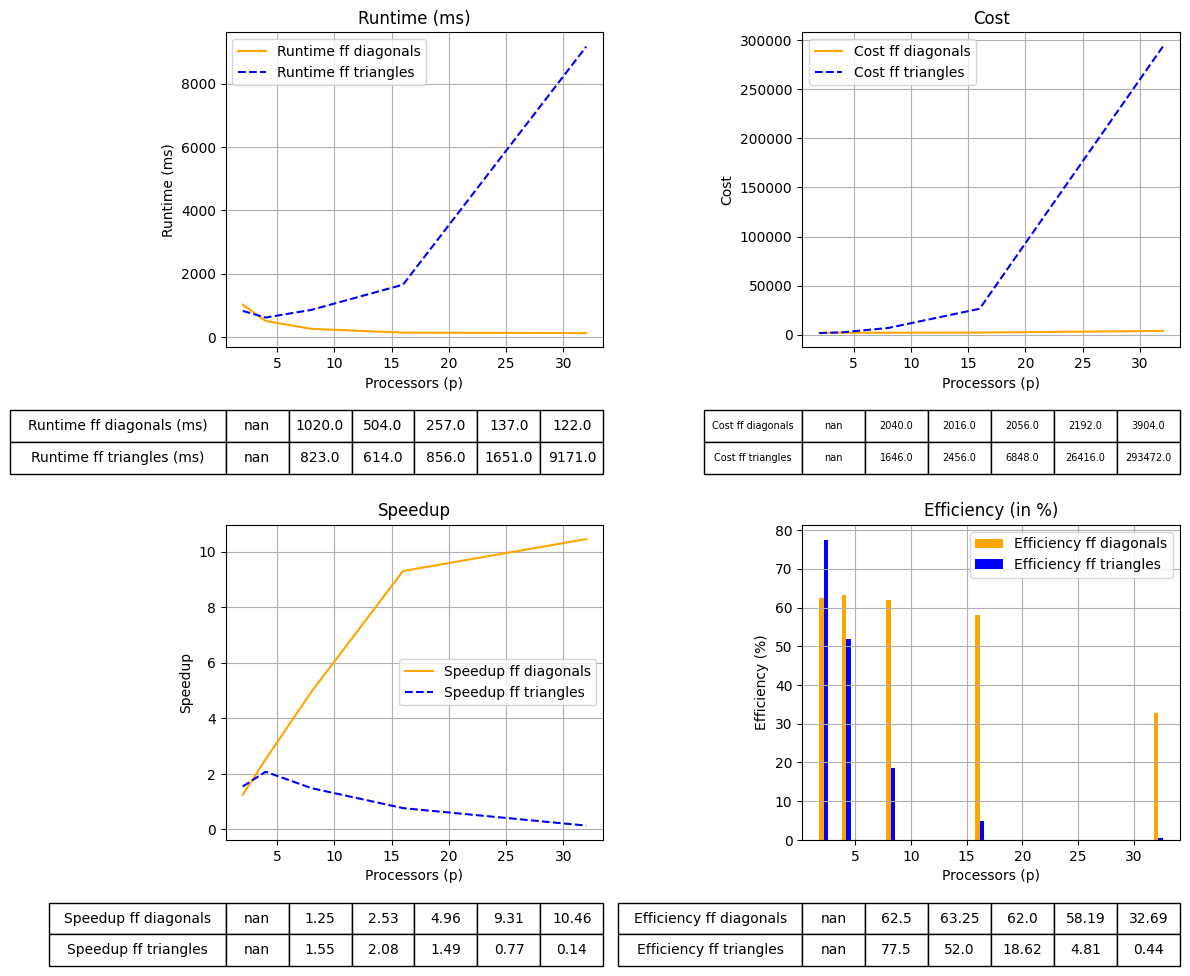


[2896, 2896, 2896, 2896, 2896, 2896]


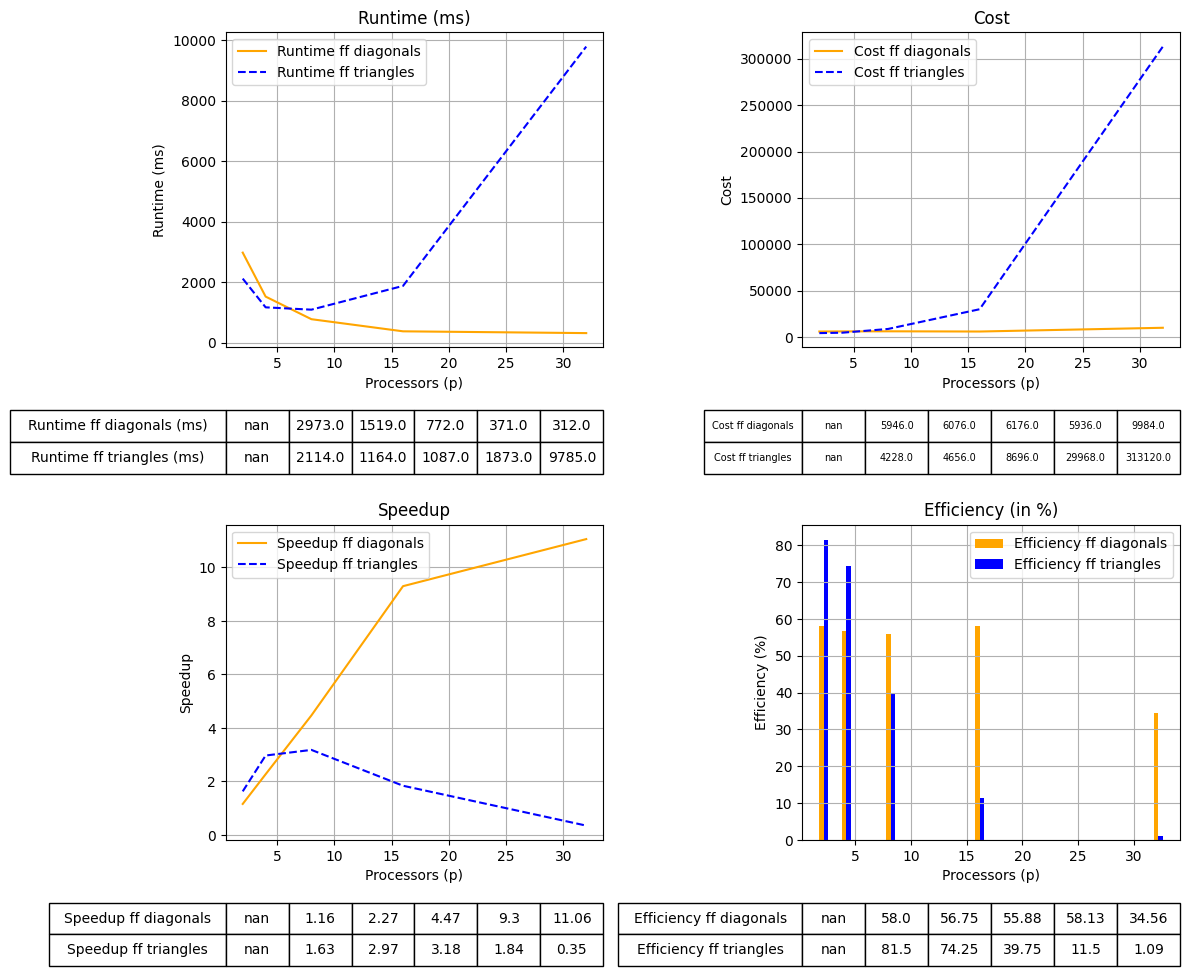


[4096, 4096, 4096, 4096, 4096, 4096]


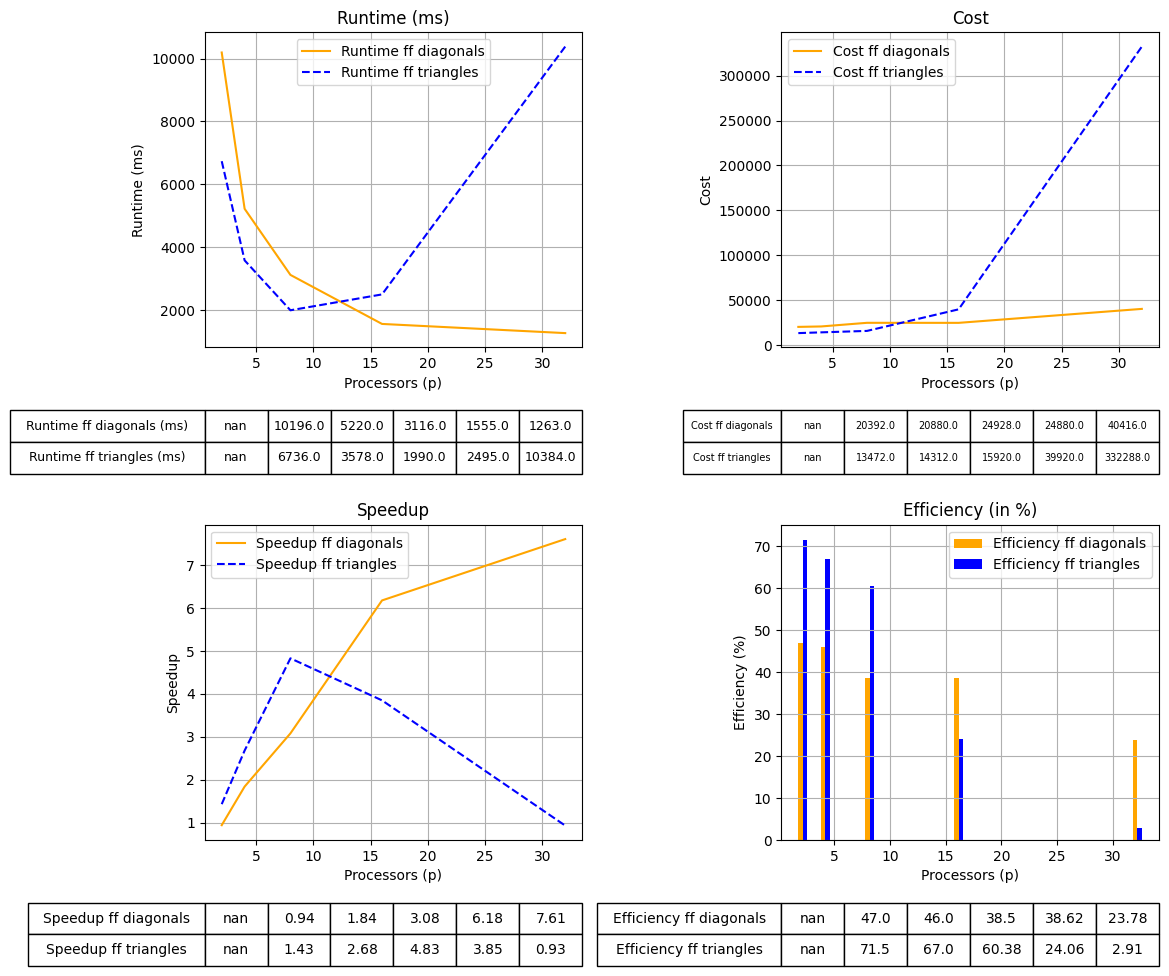


[5793, 5793, 5793, 5793, 5793, 5793]


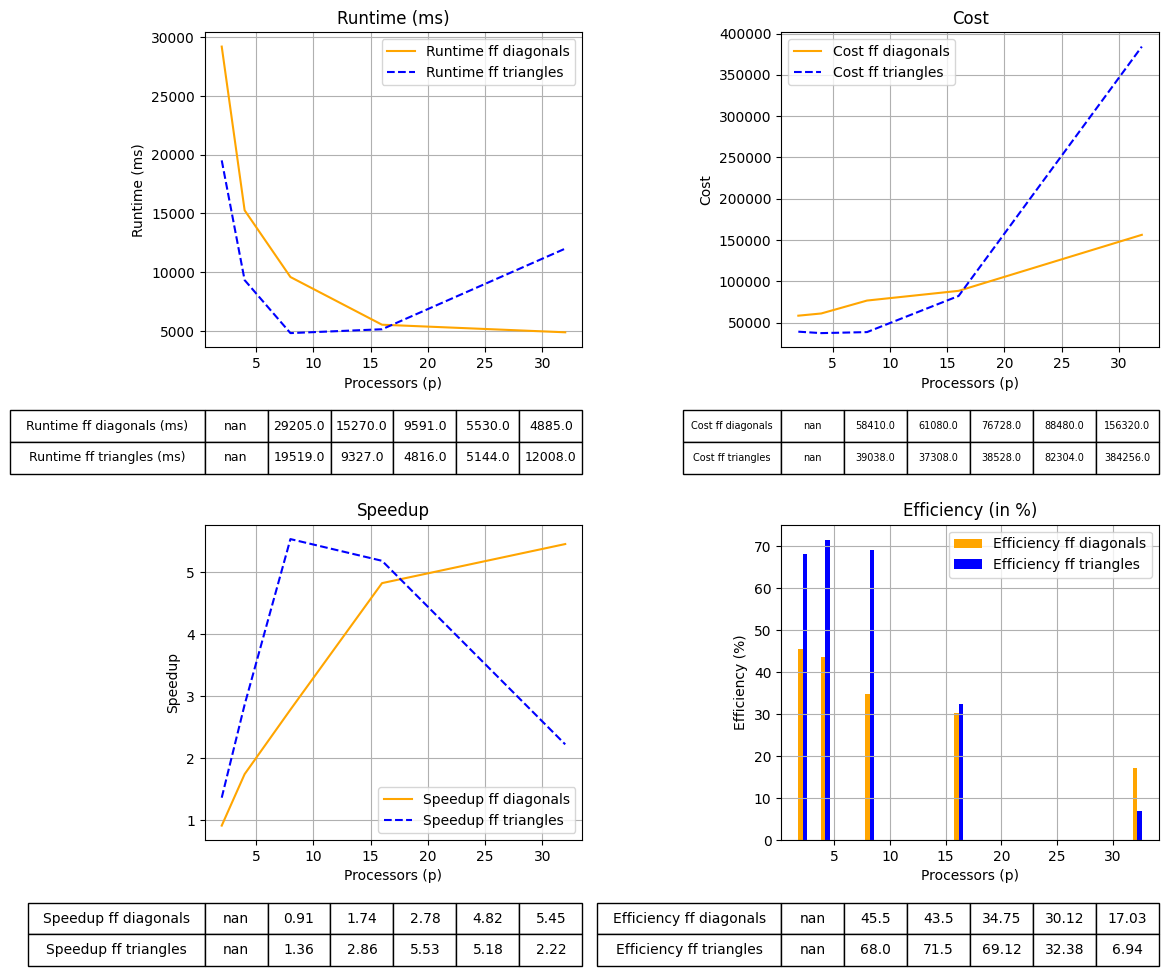


[8192, 8192, 8192, 8192, 8192, 8192]


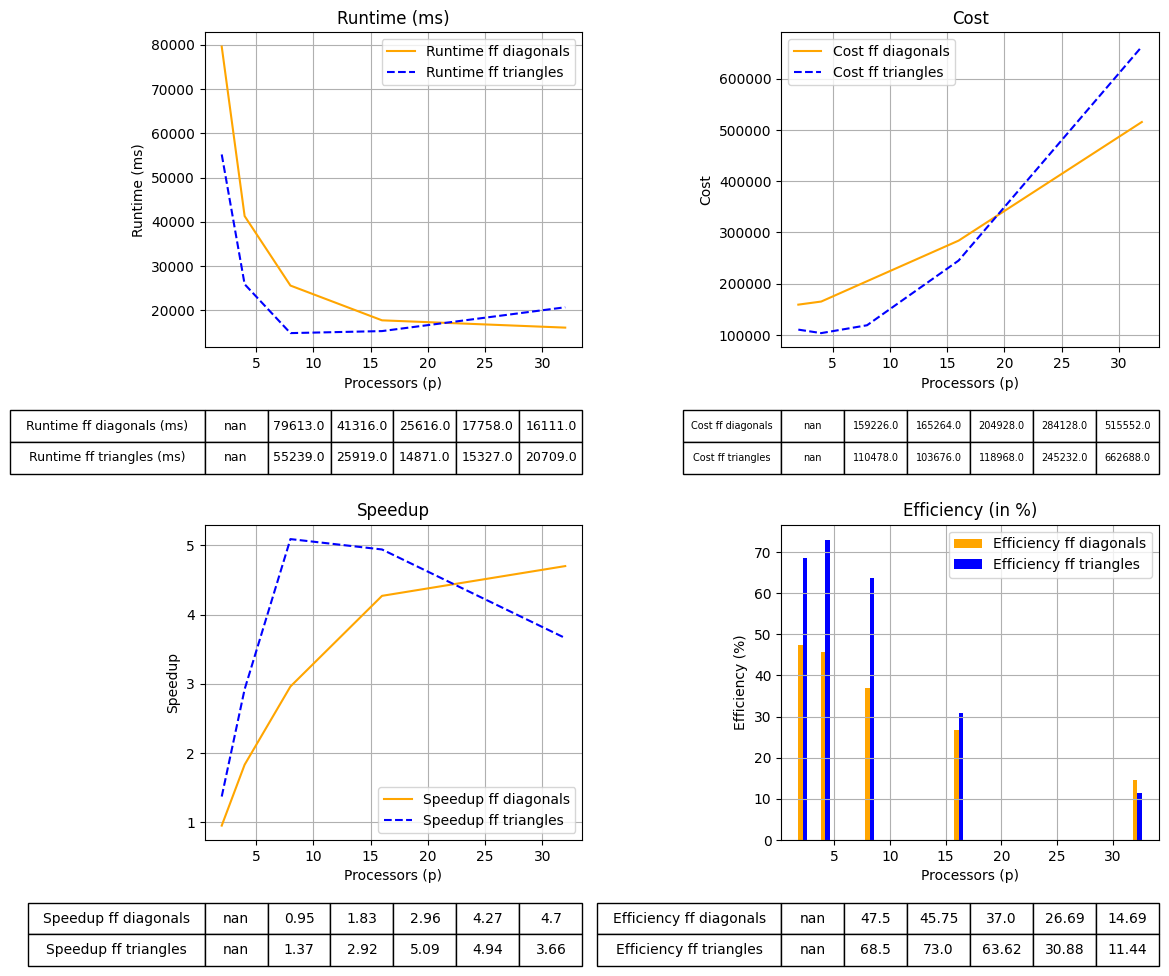

In [38]:
for strong_scalability_item in strong_scalability_data_ff:
    runtime_diag_par, speedup_diag, cost_diag, efficiency_diag, runtime_tria_par,speedup_tria, cost_tria, efficiency_tria = computeMetrics(strong_scalability_item)
    print(strong_scalability_item[DATAKeys.size])
    os.system(f'mkdir -p {strong_scalability_item[DATAKeys.path]}')
    plot_analysis(
        strong_scalability_item[DATAKeys.processors],
        runtime_diag_par,
        cost_diag,
        speedup_diag,
        efficiency_diag,
        'FF diagonals',
        runtime_tria_par,
        cost_tria,
        speedup_tria,
        efficiency_tria,
        'FF triangles',
        f'{strong_scalability_item[DATAKeys.path]}/analysis'
    ) 
    print()


### MPI AllG Strong Scalability Plots

[2048, 2048, 2048, 2048, 2048, 2048]


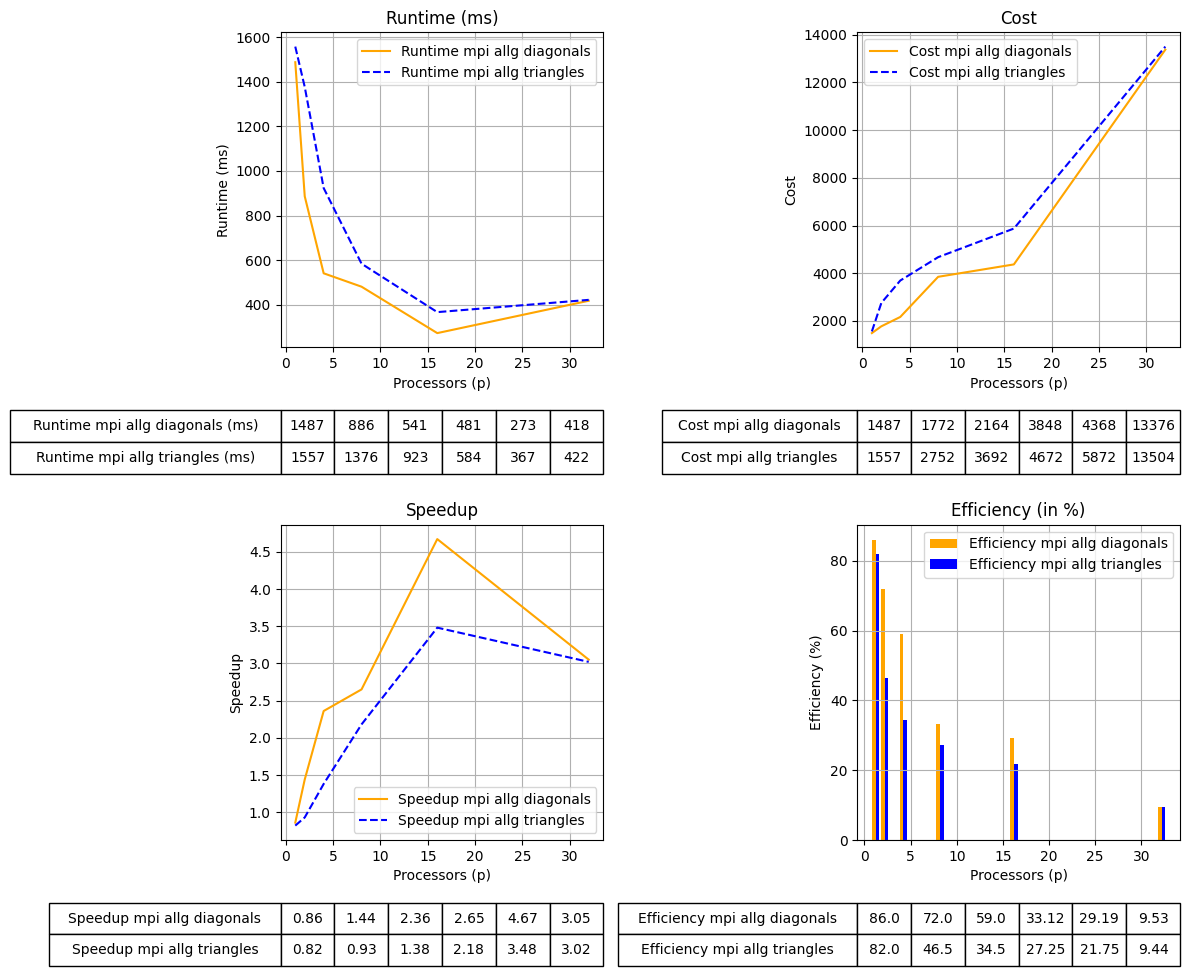


[2896, 2896, 2896, 2896, 2896, 2896]


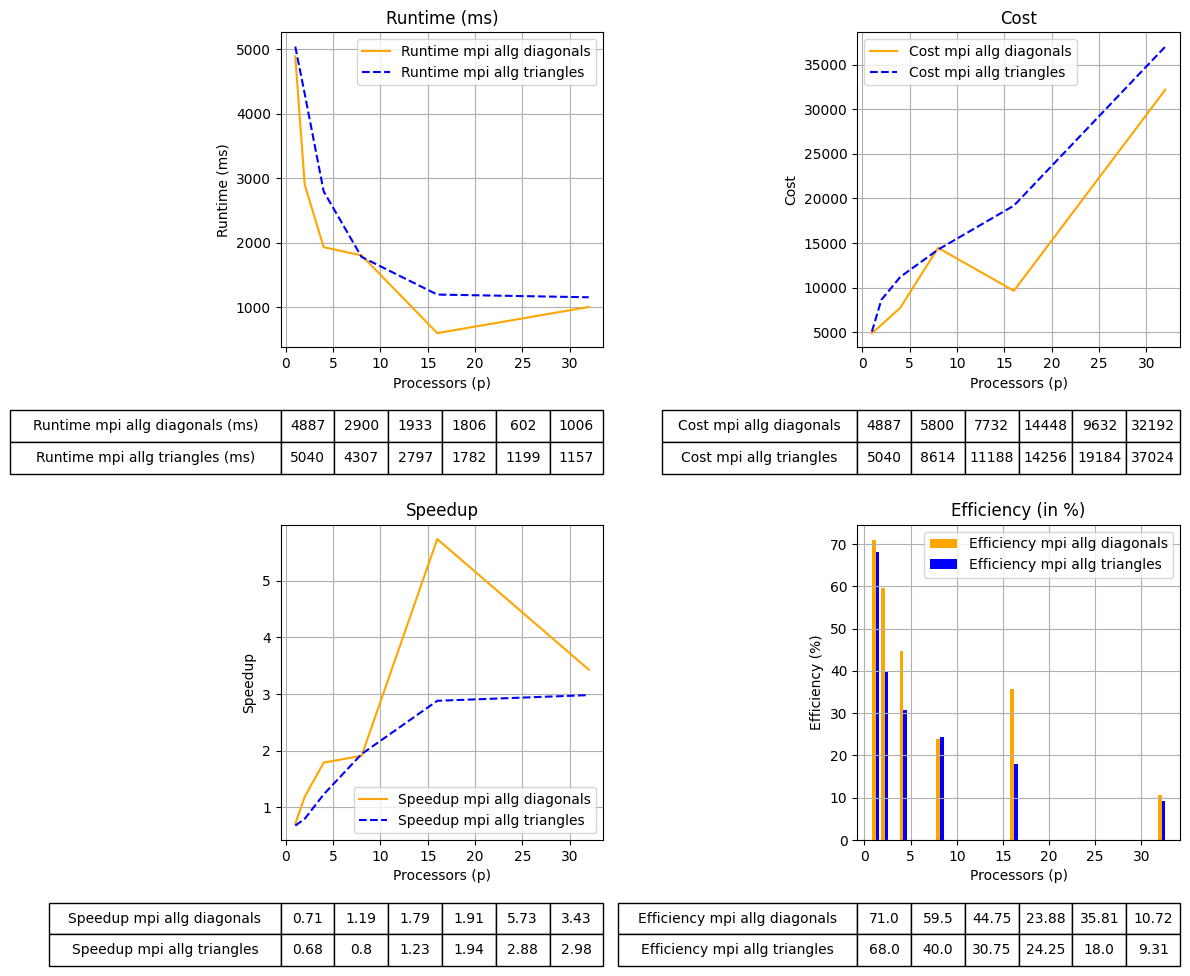


[4096, 4096, 4096, 4096, 4096, 4096]


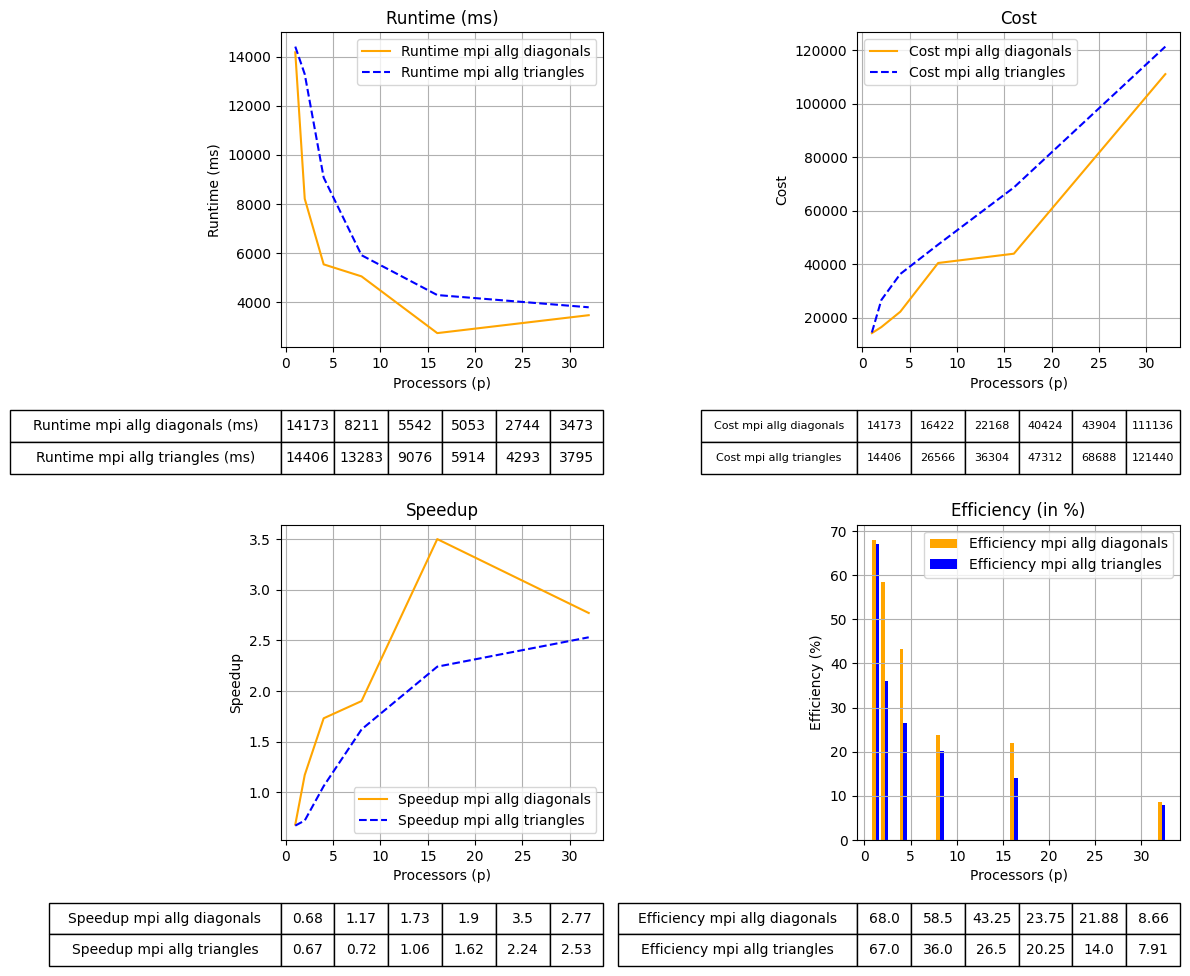


[5793, 5793, 5793, 5793, 5793, 5793]


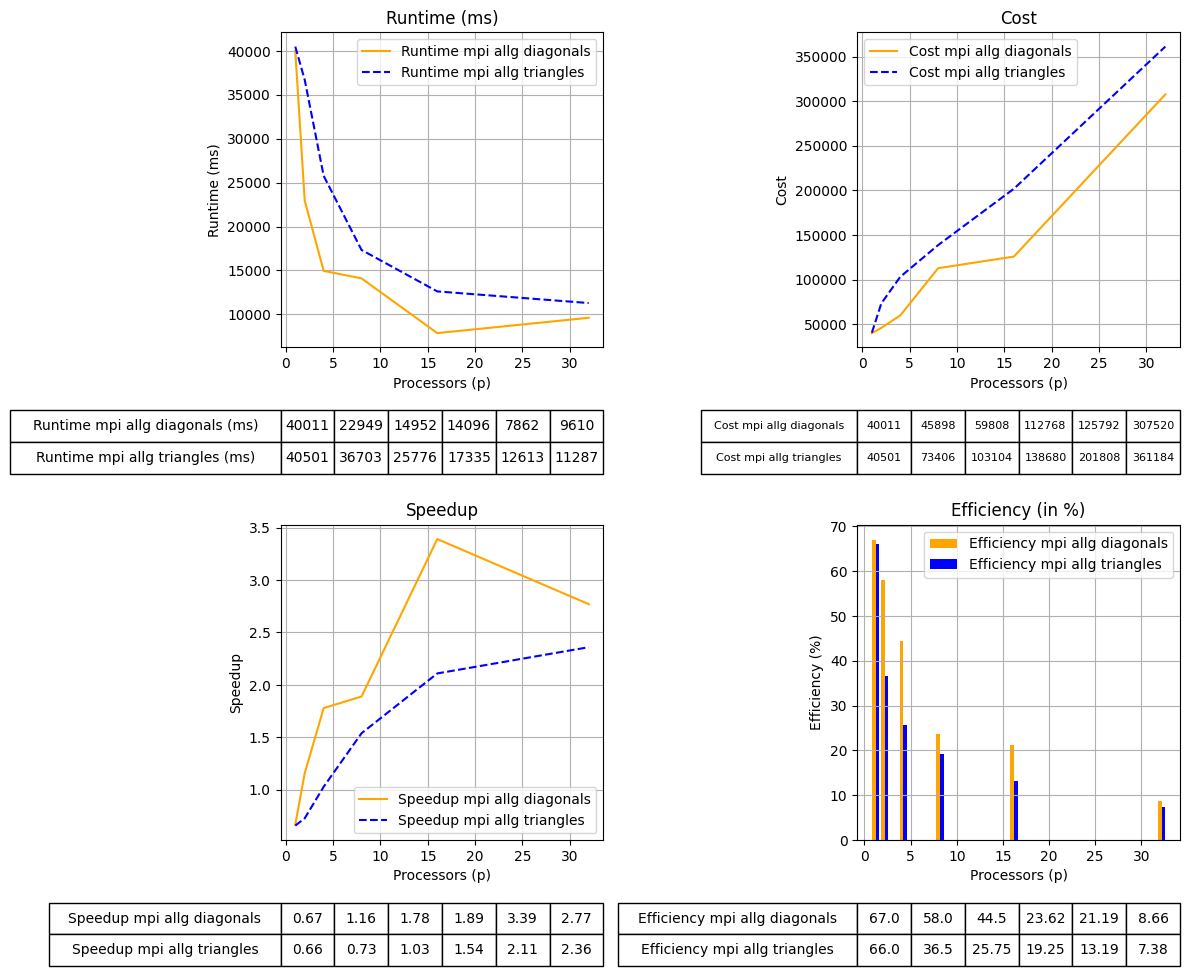


[8192, 8192, 8192, 8192, 8192, 8192]


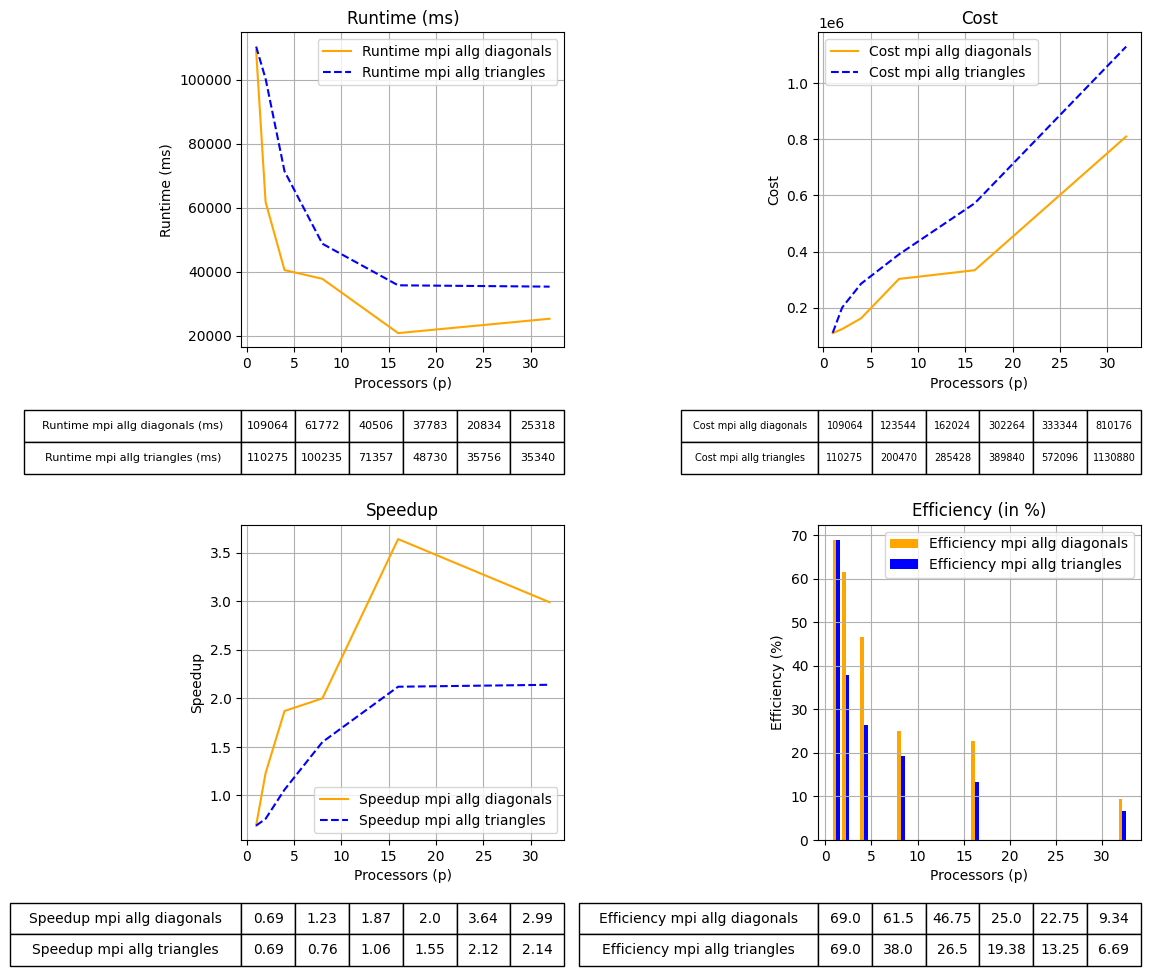

In [39]:
for strong_scalability_item in strong_scalability_data_mpi:
    runtime_diag_par, speedup_diag, cost_diag, efficiency_diag, runtime_tria_par,speedup_tria, cost_tria, efficiency_tria = computeMetrics(strong_scalability_item)
    print(strong_scalability_item[DATAKeys.size])
    os.system(f'mkdir -p {strong_scalability_item[DATAKeys.path]}')
    plot_analysis(
        strong_scalability_item[DATAKeys.processors],
        runtime_diag_par,
        cost_diag,
        speedup_diag,
        efficiency_diag,
        'MPI_AllG diagonals',
        runtime_tria_par,
        cost_tria,
        speedup_tria,
        efficiency_tria,
        'MPI_AllG triangles',
        f'{strong_scalability_item[DATAKeys.path]}/analysis'
    ) 
    print()



### FF & MPI AllG Weak Scalability Analysis

In [40]:
triangle_ff_runtimes = []
diagonal_ff_runtimes = []
seq_runtimes = []

for s, p in zip(size, processes[1:]):

    diag_seq_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_seq if runtime[CSVKeys.size] == s]
    tria_seq_runtime = [runtime[CSVKeys.runtime] for runtime in triangles_seq if runtime[CSVKeys.size] == s]
    diagonal_ff_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_ff if runtime[CSVKeys.size] == s and runtime[CSVKeys.workers] == p]
    triangle_ff_runtime = [runtime[CSVKeys.runtime] for runtime in triangles_ff if runtime[CSVKeys.size] == s and runtime[CSVKeys.workers] == p]
    
    diagonal_ff_runtimes.append(diagonal_ff_runtime[0])
    triangle_ff_runtimes.append(triangle_ff_runtime[0])
    seq_runtimes.append(min(min(diag_seq_runtime), min(tria_seq_runtime)))

weak_scalability_data_ff = {
    DATAKeys.processors: processes[1:],
    DATAKeys.runtime_diagonal: diagonal_ff_runtimes,
    DATAKeys.runtime_triangle: triangle_ff_runtimes,
    DATAKeys.T_seq: seq_runtimes,
    DATAKeys.path: f'./weak_scalability_plots_ff/',
    DATAKeys.size: size
}

triangle_allg_mpi_runtimes = []
diagonal_allg_mpi_runtimes = []
seq_runtimes = []

for s, p in zip(size, processes[1:]):

    diag_seq_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_seq if runtime[CSVKeys.size] == s]
    tria_seq_runtime = [runtime[CSVKeys.runtime] for runtime in triangles_seq if runtime[CSVKeys.size] == s]
    diagonal_allg_mpi_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_allg_mpi if runtime[CSVKeys.size] == s and runtime[CSVKeys.workers] == p]
    triangle_allg_mpi_runtime = [runtime[CSVKeys.runtime] for runtime in triangles_allg_mpi if runtime[CSVKeys.size] == s and runtime[CSVKeys.workers] == p]
    
    diagonal_allg_mpi_runtimes.append(diagonal_allg_mpi_runtime[0])
    triangle_allg_mpi_runtimes.append(triangle_allg_mpi_runtime[0])
    print(tria_seq_runtime)
    seq_runtimes.append(min(min(diag_seq_runtime), min(tria_seq_runtime)))

weak_scalability_data_mpi = {
    DATAKeys.processors: processes[1:],
    DATAKeys.runtime_diagonal: diagonal_allg_mpi_runtimes,
    DATAKeys.runtime_triangle: triangle_allg_mpi_runtimes,
    DATAKeys.T_seq: seq_runtimes,
    DATAKeys.path: f'./weak_scalability_plots_allg_mpi/',
    DATAKeys.size: size
}

[1458, 1312, 1276, 1294, 1352, 1442]
[4830, 3725, 3452, 3489, 3560, 3756]
[14019, 13019, 11358, 9728, 9606, 9951]
[39636, 37602, 31971, 26762, 26634, 27167]
[108900, 108026, 105244, 99525, 87705, 75747]


### FF Weak Scalability Plots

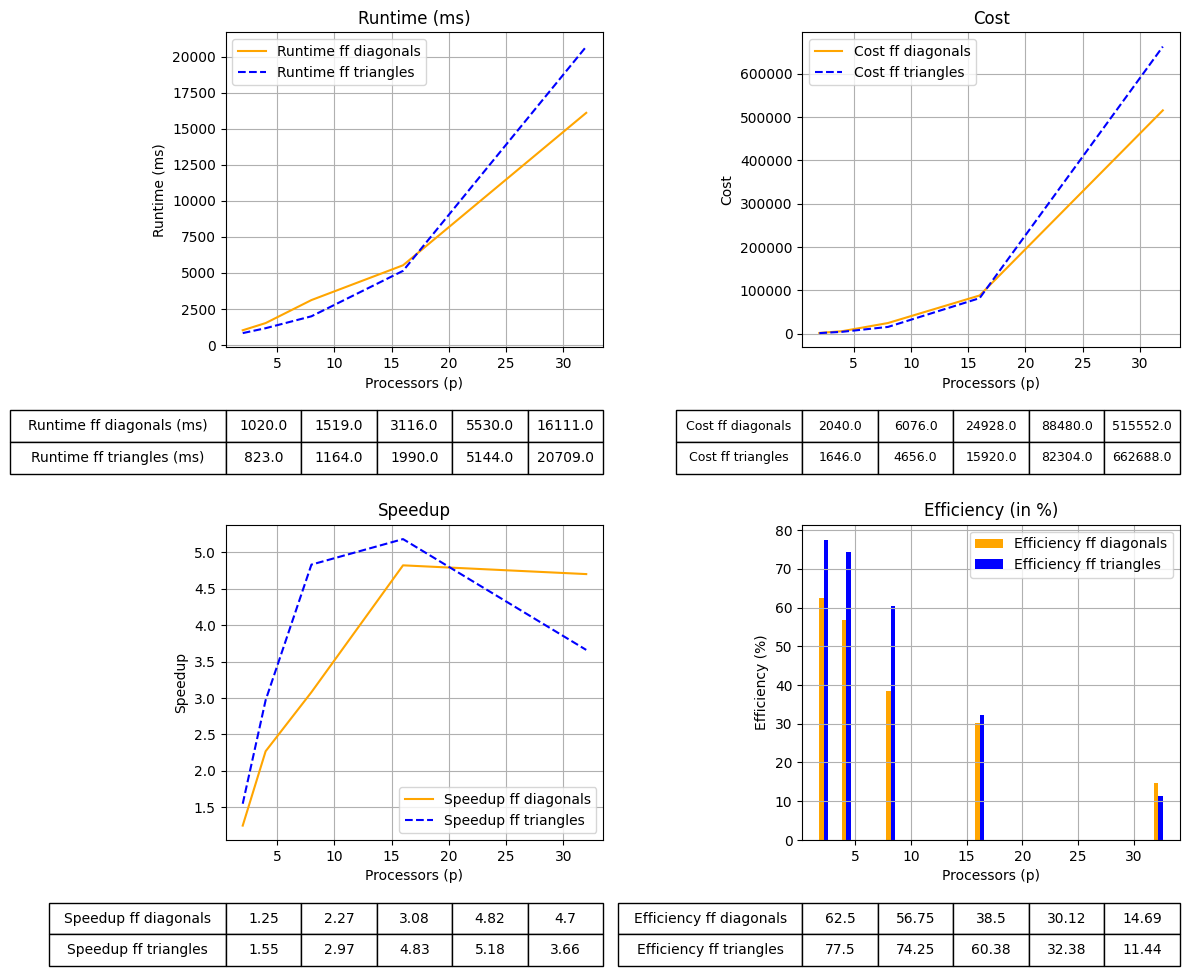

In [41]:
runtime_diag_par, speedup_diag, cost_diag, efficiency_diag, runtime_tria_par, speedup_tria, cost_tria, efficiency_tria = computeMetrics(weak_scalability_data_ff)
os.system(f"mkdir -p {weak_scalability_data_ff[DATAKeys.path]}")

plot_analysis(
    weak_scalability_data_ff[DATAKeys.processors],
    runtime_diag_par,
    cost_diag,
    speedup_diag,
    efficiency_diag,
    'FF diagonals',
    runtime_tria_par,
    cost_tria,
    speedup_tria,
    efficiency_tria,
    'FF triangles',
    f'{weak_scalability_data_ff[DATAKeys.path]}/analysis'
)

### MPI AllG Weak Scalability Plots

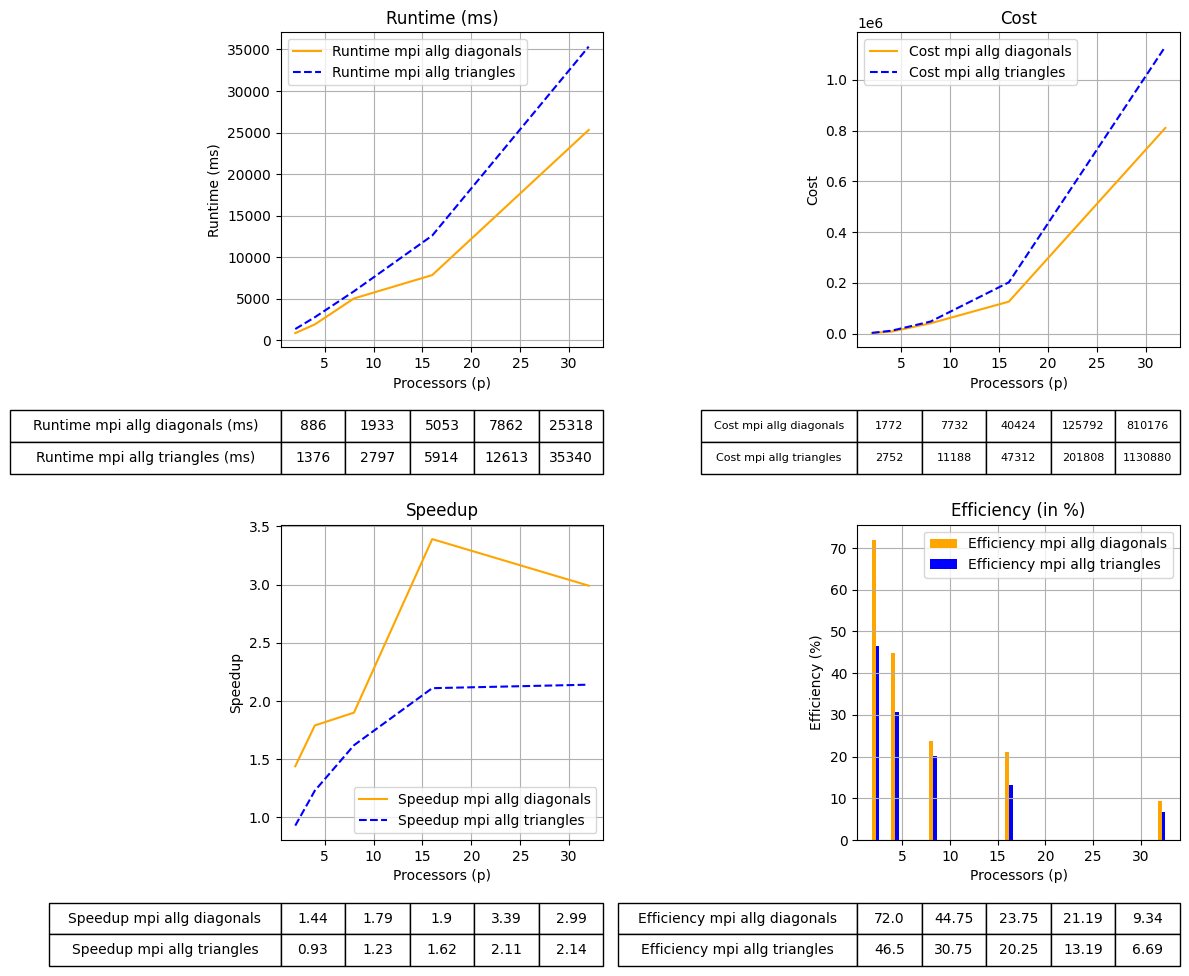

In [42]:
runtime_diag_par, speedup_diag, cost_diag, efficiency_diag, runtime_tria_par, speedup_tria, cost_tria, efficiency_tria = computeMetrics(weak_scalability_data_mpi)
os.system(f"mkdir -p {weak_scalability_data_mpi[DATAKeys.path]}")

plot_analysis(
    weak_scalability_data_mpi[DATAKeys.processors],
    runtime_diag_par,
    cost_diag,
    speedup_diag,
    efficiency_diag,
    'MPI_AllG diagonals',
    runtime_tria_par,
    cost_tria,
    speedup_tria,
    efficiency_tria,
    'MPI_AllG triangles',
    f'{weak_scalability_data_mpi[DATAKeys.path]}/analysis'
)

### Strong and Weak scaling of diagonals with ScatterGather

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michelemattiello/Desktop/unipi_SPM/ExamProjects/project1/scripts/strong_scalability_plots_sg_mpi/2048/analysis.png'

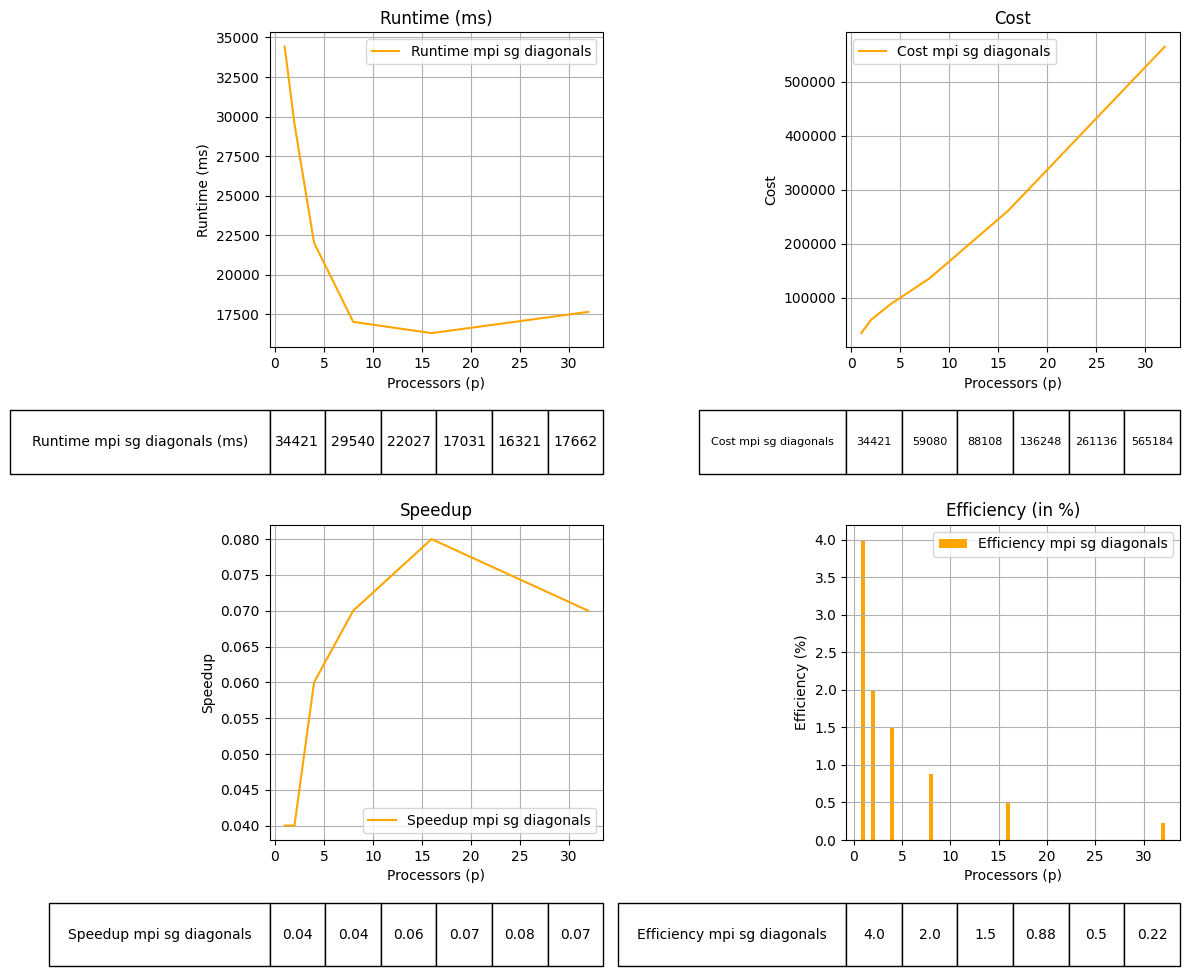

In [43]:
strong_scalability_data_sg_mpi = []
for s in size:
    diagonal_seq_runtime = [row[CSVKeys.runtime] for row in diagonal_seq if row[CSVKeys.size] == s]
    triangles_seq_runtime = [row[CSVKeys.runtime] for row in triangles_seq if row[CSVKeys.size] == s]
    diagonal_par_runtime = [row[CSVKeys.runtime] for row in diagonal_sg_mpi if row[CSVKeys.size] == s]
    t_seq = min(min(diagonal_seq_runtime), min(triangles_seq_runtime))
    strong_scalability_data_sg_mpi.append({
        DATAKeys.processors: processes,
        DATAKeys.runtime_diagonal: diagonal_par_runtime,
        DATAKeys.T_seq: t_seq,
        DATAKeys.path: f'./strong_scalability_plots_sg_mpi/{s}/',
        DATAKeys.size: [s] * len(diagonal_par_runtime),
    })

for strong_scalability_item in strong_scalability_data_sg_mpi:
    processors = strong_scalability_item[DATAKeys.processors]
    runtime_diag_par = strong_scalability_item[DATAKeys.runtime_diagonal]
    T_seq = strong_scalability_item[DATAKeys.T_seq]

    speedup_diag = []
    if isinstance(T_seq, list):
        speedup_diag = [round(t / r, 2) for t, r in zip(T_seq, runtime_diag_par)]
    else:
        speedup_diag = [round(T_seq / r, 2) for r in runtime_diag_par]

    cost_diag = [r * p for r, p in zip(runtime_diag_par, processors)]
    efficiency_diag = [round(100 * s / p, 2) for s, p in zip(speedup_diag, processors)]

    plot_single_analysis(
        strong_scalability_item[DATAKeys.processors],
        runtime_diag_par,
        cost_diag,
        speedup_diag,
        efficiency_diag,
        'MPI_SG diagonals',
        f'{strong_scalability_item[DATAKeys.path]}/analysis'
    )


In [ ]:
diagonal_sg_mpi_runtimes = []
seq_runtimes = []

for s, p in zip(size, processes):

    diag_seq_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_seq if runtime[CSVKeys.size] == s]
    tria_seq_runtime = [runtime[CSVKeys.runtime] for runtime in triangles_seq if runtime[CSVKeys.size] == s]
    diagonal_sg_mpi_runtime = [runtime[CSVKeys.runtime] for runtime in diagonal_sg_mpi if runtime[CSVKeys.size] == s and runtime[CSVKeys.workers] == p]
    print(diagonal_sg_mpi)
    print(diagonal_sg_mpi_runtime)
    diagonal_sg_mpi_runtimes.append(diagonal_sg_mpi_runtime[0])
    seq_runtimes.append(min(min(diag_seq_runtime), min(tria_seq_runtime)))

weak_scalability_data_sg_mpi = {
    DATAKeys.processors: processes,
    DATAKeys.runtime_diagonal: diagonal_sg_mpi_runtimes,
    DATAKeys.runtime_triangle: [],
    DATAKeys.T_seq: seq_runtimes,
    DATAKeys.path: f'./strong_scalability_plots_sg_mpi/',
    DATAKeys.size: size
}
runtime_diag_par, speedup_diag, cost_diag, efficiency_diag, _, _, _, _ = computeMetrics(weak_scalability_data_sg_mpi)
os.system(f"mkdir -p {weak_scalability_data_sg_mpi[DATAKeys.path]}")
plot_single_analysis(
    weak_scalability_data_sg_mpi[DATAKeys.processors],
    runtime_diag_par,
    cost_diag,
    speedup_diag,
    efficiency_diag,
    'MPI_SG diagonals',
    f'{weak_scalability_data_sg_mpi[DATAKeys.path]}/analysis'
)